In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset
from dnn_utils_v2 import sigmoid, sigmoid_backward, relu, relu_backward
%matplotlib inline
plt.rcParams['figure.figsize']=(5.0,4.0)
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [1], it's a 'cat' picture.


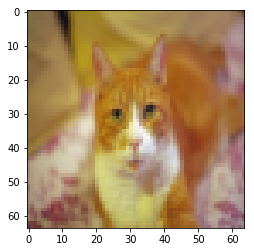

In [3]:
#Haciendo la prueba de una imágen
index = 24
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [4]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[2]

print("Cantidad de Ejemplos de entrenamiento: " + str(m_train))
print("Cantidad de Ejemplos de prueba: " + str(m_test))
print("Altura de la Imagen: " + str(num_px))

Cantidad de Ejemplos de entrenamiento: 209
Cantidad de Ejemplos de prueba: 50
Altura de la Imagen: 64


In [5]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

In [6]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

In [7]:
n_x = train_set_x_flatten.shape[0]  
n_y = 1 
nn_layers = [n_x, 20, 7, 5, n_y] 
nn_layers

[12288, 20, 7, 5, 1]

In [8]:
# FUNCION: initialize_parameters
def initialize_parameters(layer_dims):
    
    parameters = {}
    L = len(layer_dims)          
 
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
 
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
 
    return parameters 

In [9]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
 
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
 
    return Z, cache

In [10]:
def sigmoid(Z):

    A = 1/(1+np.exp(-Z))
    cache = Z
 
    return A, cache

In [11]:
def relu(Z):

    A = np.maximum(0,Z) 
    assert(A.shape == Z.shape)
    cache = Z
    return A, cache

In [12]:
def linear_activation_forward(A_prev, W, b, activation):
 
    Z, linear_cache = linear_forward(A_prev, W, b)
 
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
 
    elif activation == "relu":
        A, activation_cache = relu(Z)
 
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
 
    return A, cache

In [13]:
def L_model_forward(X, parameters):
 
    caches = []
    A = X
    L = len(parameters) // 2                  
    for l in range(1, L):
        A_prev = A
        w_l = parameters['W' + str(l)]
        b_l = parameters['b' + str(l)]
        A, cache = linear_activation_forward(A_prev, w_l, b_l, activation = "relu")
        caches.append(cache)
    w_L = parameters['W' + str(L)]
    b_L = parameters['b' + str(L)]
    Yhat, cache = linear_activation_forward(A, w_L, b_L, activation = "sigmoid")
    caches.append(cache)
 
    assert(Yhat.shape == (1,X.shape[1]))
 
    return Yhat, caches

In [14]:
def compute_cost(Yhat, Y):

    m = Y.shape[1]

    logprobs = np.dot(Y, np.log(Yhat).T) + np.dot((1-Y), np.log(1-Yhat).T)
 
    cost = (-1./m) * logprobs 
 
    cost = np.squeeze(cost)      
 
    return cost

In [15]:
 
def linear_backward(dZ, cache):

    A_prev, W, b = cache
    m = A_prev.shape[1]
 
    dW = (1./m) * np.dot(dZ, A_prev.T)
    db = (1./m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
 
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
 
    return dA_prev, dW, db

In [16]:
def sigmoid_backward(dA, cache):
 
    Z = cache
 
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
 
    assert (dZ.shape == Z.shape)
 
    return dZ

In [17]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) 
    dZ[Z <= 0] = 0         
    assert (dZ.shape == Z.shape)          
    return dZ

In [18]:
def linear_activation_backward(dA, cache, activation):     

    linear_cache, activation_cache = cache
 
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
 
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
 
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
 
    return dA_prev, dW, db

In [19]:
def L_model_backward(Yhat, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = Yhat.shape[1]
    Y = Y.reshape(Yhat.shape) # after this line, Y is the same shape as AL
 
    dAL = - (np.divide(Y, Yhat) - np.divide(1 - Y, 1 - Yhat)) 
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
 
    for l in reversed(range(L-1)):

        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA"+str(l+2)], current_cache, activation = "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
 
    return grads

In [20]:
def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2 
    for l in range(L):
        parameters["W"+str(l+1)] = parameters["W"+str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b"+str(l+1)] = parameters["b"+str(l+1)] - learning_rate * grads["db" + str(l+1)]
    return parameters

In [21]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.025, num_iterations = 1000, print_cost=False):
    
    costs = []       
    parameters = initialize_parameters(layers_dims)
 

    for i in range(0, num_iterations):
 
        AL, caches = L_model_forward(X, parameters)

        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
 

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
 
    return parameters

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.655807
Cost after iteration 200: 0.646407
Cost after iteration 300: 0.643208
Cost after iteration 400: 0.640453
Cost after iteration 500: 0.631623
Cost after iteration 600: 0.558153
Cost after iteration 700: 0.549866
Cost after iteration 800: 0.376730
Cost after iteration 900: 0.505889
Cost after iteration 1000: 0.202702
Cost after iteration 1100: 0.144790
Cost after iteration 1200: 0.099153
Cost after iteration 1300: 0.081252
Cost after iteration 1400: 0.070883
Cost after iteration 1500: 0.063787
Cost after iteration 1600: 0.060090
Cost after iteration 1700: 0.056909
Cost after iteration 1800: 0.055080
Cost after iteration 1900: 0.053825
Cost after iteration 2000: 0.052873
Cost after iteration 2100: 0.052385
Cost after iteration 2200: 0.051956
Cost after iteration 2300: 0.051357
Cost after iteration 2400: 0.051323
Cost after iteration 2500: 0.050832
Cost after iteration 2600: 0.050670
Cost after iteration 2700: 0.050506
Cost

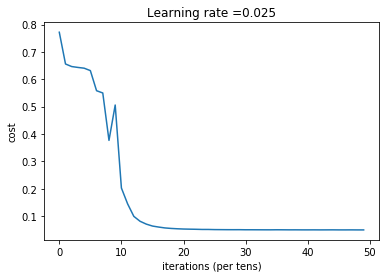

In [26]:
np.random.seed(1)
 
fit_params = L_layer_model(train_set_x, train_set_y, nn_layers, num_iterations = 5000, print_cost = True)


In [27]:
def predict(X, y, parameters):

    m = X.shape[1]
    n = len(parameters) // 2 
    p = np.zeros((1,m))
 
    probas, caches = L_model_forward(X, parameters)
 
    for i in range(0, probas.shape[1]):
        if probas[0,i] >= 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    print("Accuracy: "  + str(np.sum((p == y)/m)))
 
    return p

In [28]:
pred_train = predict(train_set_x, train_set_y, fit_params)


Accuracy: 0.9904306220095691


In [29]:
pred_test = predict(test_set_x, test_set_y, fit_params)


Accuracy: 0.8200000000000001
